<a href="https://colab.research.google.com/github/probabll/bda.length/blob/main/Rank-Frequency%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
pip install numpyro funsor

In [3]:
import numpy as np
import numpyro

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

In [5]:
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
palette = cycle(sns.color_palette())
color_m = next(palette)
color_f = next(palette)

In practice, you probably want to load some model outputs (or data samples) and tokenize it as your model would (e.g., using sentencepiece). For this demo, I will just generate data from some Poissons and mixture of Poissons.

In [6]:
import scipy.stats as st
import scipy.special as sps
from itertools import groupby

In [7]:
def sort_and_count(x):
  return np.array([[key, len(list(values))] for key, values in groupby(np.sort(x))])

In [8]:
def plot_density(a, N=1000, K=50, ax=None):
  if ax is None:
    ax = plt
  if a <= 1.0:
    raise ValueError("The Zipf parameter must be greater than one")
  s = np.random.zipf(a, size=N)    
  count, bins, ignored = ax.hist(s[s<K], K, density=True)
  x = np.arange(1., K)
  y = x**(-a)/sps.zetac(a)
  return ax.plot(x, y/max(y), linewidth=2, color='r')

def plot_draws(x, N=1000, K=50, ax=None, **kwargs):
  if ax is None:
    ax = plt
  return ax.hist(x[x<K], K, density=True, **kwargs)

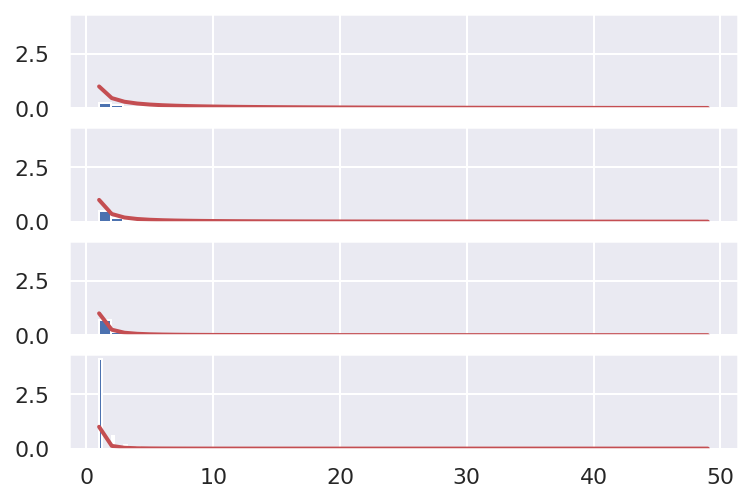

In [9]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
_ = plot_density(1.1, ax=axs[0])
_ = plot_density(1.5, ax=axs[1])
_ = plot_density(2., ax=axs[2])
_ = plot_density(3., ax=axs[3])

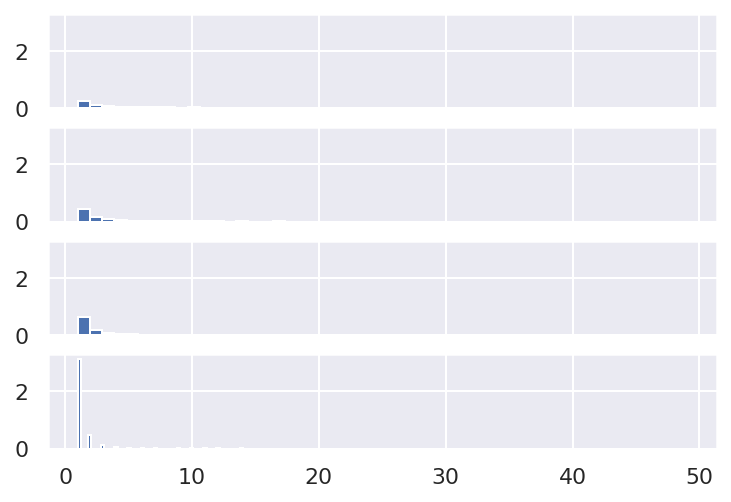

In [10]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
_ = plot_draws(np.random.zipf(1.1, size=1000), ax=axs[0])
_ = plot_draws(np.random.zipf(1.5, size=1000), ax=axs[1])
_ = plot_draws(np.random.zipf(2., size=1000), ax=axs[2])
_ = plot_draws(np.random.zipf(3., size=1000), ax=axs[3])

You would probably want to

1. load some text files
2. tokenize them (as your model would, or as most suit your needs)
3. map words to their frequency's rank (e.g., if `the` is the most frequency word, it gets rank 1, so every occurrence of `the` should be mapped to the integer `1`).

For this demo, I am drawing directly from Zipf distributions (or mixtures thereof).

In [11]:
def generate_data(size=1000):
  names = ['a1.5 (i)', 'a1.5 (ii)', 'a1.8', 'a2.', 'a1.5|2.']
  data = [
    np.random.zipf(1.5, size=size),
    np.random.zipf(1.5, size=size),
    np.random.zipf(1.8, size=size),
    np.random.zipf(2., size=size),
    np.where(np.random.uniform(size=size) > 0.5, np.random.zipf(1.5, size=size), np.random.zipf(2., size=size)),
  ]
  return names, data

In [12]:
group_names, all_data = generate_data()  # the data vectors need not all have the same length

In [13]:
loglog_pairs = [np.log(sort_and_count(D)) for D in all_data]

In [14]:
headers = ['Stats'] + group_names
rows = [
    ['size'] + [np.size(obs) for obs in all_data],
    ['mean'] + [np.mean(obs) for obs in all_data],
    ['std'] + [np.std(obs) for obs in all_data],
    ['median'] + [np.median(obs) for obs in all_data],
    ['min'] + [np.min(obs) for obs in all_data],
    ['max'] + [np.max(obs) for obs in all_data],
]
print(tabulate(rows, headers=headers, floatfmt='.2f'))

Stats       a1.5 (i)    a1.5 (ii)      a1.8      a2.    a1.5|2.
-------  -----------  -----------  --------  -------  ---------
size         1000.00      1000.00   1000.00  1000.00    1000.00
mean        50789.03       744.80    108.75     5.84     945.41
std       1146847.03     19801.13   2944.61    55.91   18519.26
median          3.00         2.00      1.00     1.00       2.00
min             1.00         1.00      1.00     1.00       1.00
max      30413810.00    624469.00  93057.00  1714.00  430917.00


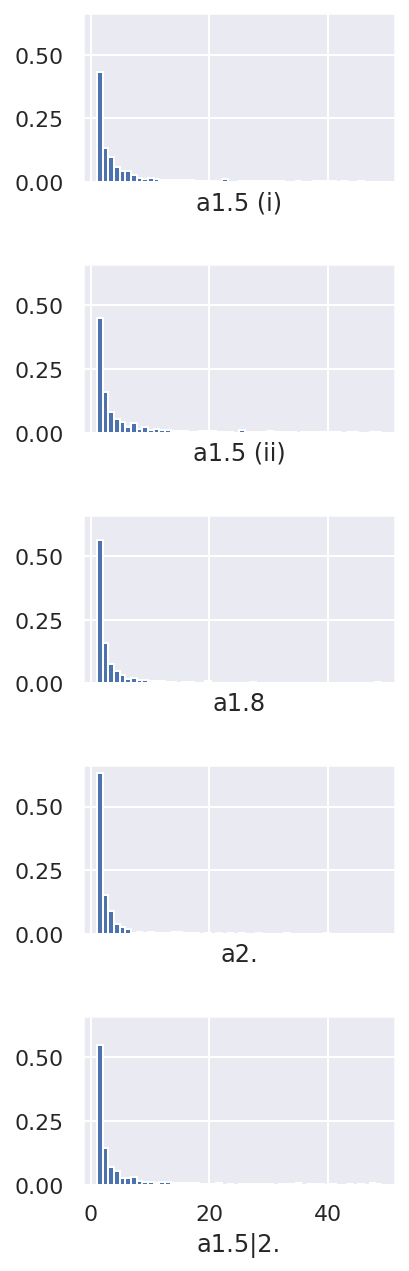

In [15]:
fig, ax = plt.subplots(len(all_data), 1, sharex=True, sharey=True, figsize=(3, 9))
for g in range(len(all_data)):
    _ = plot_draws(all_data[g], ax=ax[g])    
    ax[g].set_xlabel(group_names[g])
fig.tight_layout(h_pad=2, w_pad=2)

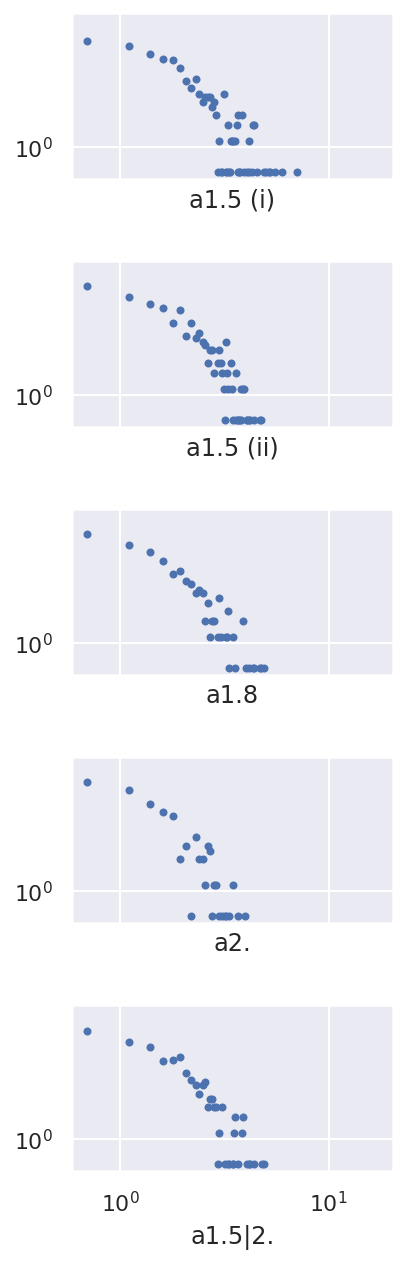

In [16]:
fig, ax = plt.subplots(len(all_data), 1, sharex=True, sharey=True, figsize=(3, 9))
for g in range(len(all_data)):
    _ = ax[g].loglog(loglog_pairs[g][:, 0], loglog_pairs[g][:, 1], '.')
    ax[g].set_xlabel(group_names[g])
fig.tight_layout(h_pad=2, w_pad=2)

In [17]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import tensorflow_probability.substrates.jax.distributions as tfd  # numpyro can handle numpyro dists, torch dists and tf dists :D (and tf has Zipf)
from jax import random
import jax.numpy as jnp
import jax
from numpyro.contrib.indexing import Vindex

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
print(f"Running on NumPryo v{numpyro.__version__}")

Running on NumPryo v0.8.0


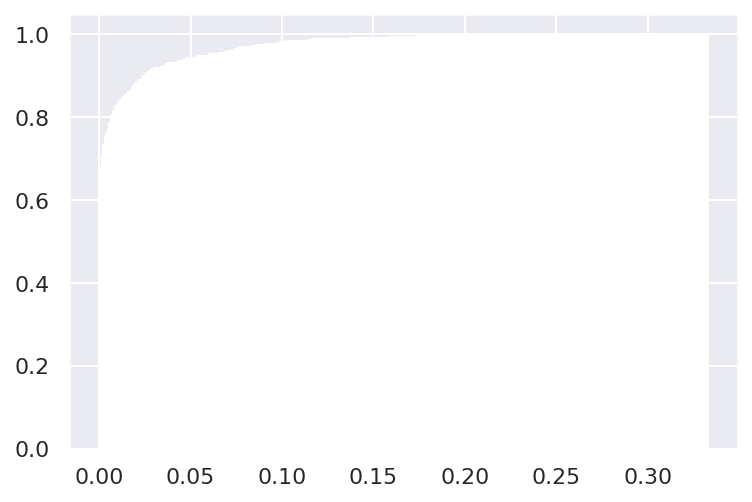

In [18]:
_ = plt.hist(np.random.gamma(0.1, 0.1, 1000) , bins='auto', density=True, cumulative=True)

In [19]:
class DPMixture:
    def __init__(self, group_names: list, observations: list, 
                 gamma_shape=[1., 1.], DP_alpha=1., PY_alpha=0.,  num_comps=5,
                 num_samples=1000, num_chains=1, num_warmup=100):

        self.gamma_shape = gamma_shape
        self.DP_alpha = DP_alpha
        self.PY_alpha = PY_alpha
        self.T = num_comps

        self.group_names = group_names
        self.G = len(group_names)
        
        self.N = sum(len(y) for y in observations)
        # [N]
        self.x = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
        self.y = np.concatenate(observations)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None

    @classmethod
    def mix_weights(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)), constant_values=1)
    
    @classmethod
    def mix_weights1d(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 1),), constant_values=1) * jnp.pad(beta1m_cumprod, ((1, 0),), constant_values=1)

    def model(self, y=None):
        """
        Pyro joint distribution.
        
        Parameter:
        
        y: observations as returned by self.prepare or None. 
            If None, the 'obs' node of the graphical model will be resampled.
        """

        N, G = self.N, self.G
        T = self.T

        with numpyro.plate("components", T):  
            # construct the components
            # [T]
            lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))               
            # we need to shift it by 1, since the Zipf's power must be strictly larger than 1.0
            power = numpyro.deterministic("power", jnp.sort(1 + lamb))  

        if G > 1:
            # Sample mixing weights    
            with numpyro.plate("DPs", G):
              # [G, T-1]
              beta = numpyro.sample(
                  "beta", 
                  dist.Beta(
                      np.ones(T-1), 
                      np.arange(1, T) * self.PY_alpha  + np.ones(T-1) * self.DP_alpha
                  ).to_event(1)
              )
            # [G, T]
            omega = numpyro.deterministic("omega", self.mix_weights(beta))
            # [N, T]
            omega_x = numpyro.deterministic("omega_x", omega[self.x])
        elif G == 1:            
            # [T-1]
            beta = numpyro.sample(
                "beta", 
                dist.Beta(
                    np.ones(T-1), 
                    np.arange(1, T) * self.PY_alpha  + np.ones(T-1) * self.DP_alpha
                ).to_event(1)
            )
            # [T]
            omega = numpyro.deterministic("omega", self.mix_weights1d(beta))
            # [N, T]
            omega_x = Vindex(jnp.expand_dims(omega, -2))[jnp.zeros_like(self.x)]
        else:
            raise ValueError("I need at least 1 group")

        with numpyro.plate("observations", N):            
            # [N]            
            z = numpyro.sample("z", dist.Categorical(probs=omega_x)) 

            # [N]
            # Construct the likelihood function            
            return numpyro.sample("y", tfd.Zipf(power[z]), obs=y)

    def run(self):
        self.mcmc.run(self.rng_key, y=self.y)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key) 
        return self.prior_predictive(rng_key_, y=None)

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples, infer_discrete=False)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, y=None)
    
    @classmethod
    def _select_local_rates(cls, rates, z):
        """
        rates [num_samples, num_components]: these are positive scalars
        z [num_samples, data_size]: these are integers in [0, num_components)
        output: [num_samples, data_size] positive scalars
            which are the rates selected by z for each data point

        z should come from Predictive with infer_discrete=True and conditioned on observations
        """
        T = model.T
        return (jax.nn.one_hot(z, T) *  jnp.expand_dims(rates, -2)).sum(-1)

    def infer_local_assignments(self, posterior_samples, y):
        """
        Annotate y with z given posterior samples and y.
        
        Common use: infer_local_assignments(model.posterior_samples, model.y)
        
        Return: dictionary with local assignments
            * z: [num_samples, data_size]
            * rate_z: [num_samples, data_size]
        """
        if self.posterior_samples is None:
            raise ValueError("I need posterior samples that are paired with y samples (or observations)")
            posterior_samples = model.posterior_samples
        if y is None:
            raise ValueError("I need y samples (or observations) that are paired with posterior samples")
        
        rng_key, rng_key_ = random.split(self.rng_key)
        predictive = Predictive(self.model, posterior_samples, infer_discrete=True)
        discrete_samples = predictive(rng_key_, y=y)
        z = discrete_samples['z']
        rates_z = self._select_local_rates(posterior_samples['rate'], z)
        return {'z': z, 'rate_z': rates_z}

In [20]:
def plot_predictions(model, samples, bins=[20, 100], density=[True, True], sharex=True, sharey=True, figsize=(10, 5), kind='draws'):
    fig, ax = plt.subplots(model.G, 2, sharex=sharex, sharey=sharey, figsize=figsize)
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        c = next(pal)          
        if kind == 'hist':
          _ = ax[k, 0].hist(yk, bins=bins[0], color=c, density=density[0])
        elif kind == 'loglog':
          pairs = np.log(sort_and_count(yk.flatten()))
          _ = ax[k, 0].loglog(pairs[:, 0], pairs[:, 1], '.')
        else:
          _ = plot_draws(yk, ax=ax[k, 0])
        _ = ax[k, 0].set_xlabel(f'obs: {model.group_names[k]}')
        if kind == 'hist':
          _ = ax[k, 1].hist(yk_.flatten(), bins=bins[1], color=c, density=density[1])
        elif kind == 'loglog':
          pairs_ = np.log(sort_and_count(yk_.flatten()))
          _ = ax[k, 1].loglog(pairs_[:, 0], pairs_[:, 1], '.')
        else:
          _ = plot_draws(yk_.flatten(), ax=ax[k, 1])
        _ = ax[k, 1].set_xlabel(f'predictive: {model.group_names[k]}')

    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

def plot_checks(model, samples, bins=30, sharex=False, sharey=True, figsize=(15, 5)):
    fig, ax = plt.subplots(model.G, 4, sharex=sharex, sharey=sharey, figsize=figsize)
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        c = next(pal)
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        
        _ = ax[k, 0].hist(np.mean(yk_, 1), bins=bins, color=c, label='pred' if k == 0 else None)
        _ = ax[k, 0].axvline(np.mean(yk), color='black', linestyle='--', label='obs' if k == 0 else None)    
        _ = ax[k, 0].set_xlabel(f'E[Y{k}]')
        
        _ = ax[k, 1].hist(np.std(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 1].axvline(np.std(yk), color='black', linestyle='--')
        _ = ax[k, 1].set_xlabel(f'std[Y{k}]')

        _ = ax[k, 2].hist(np.median(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 2].axvline(np.median(yk), color='black', linestyle='--')
        _ = ax[k, 2].set_xlabel(f'median[Y{k}]')

        pvalues = np.mean(yk_ > yk, 1)
        _ = ax[k, 3].hist(pvalues, bins=bins)
        _ = ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
        _ = ax[k, 3].axvline(np.median(pvalues), color='black', linestyle=':', label='median' if k==0 else None)

    _ = fig.legend(loc='upper center', ncol=3)
    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

In [21]:
model = DPMixture(
    group_names,
    all_data,
    gamma_shape=[1., 1.], 
    num_comps=5,
    DP_alpha=0.5, 
    PY_alpha=0., 
    num_chains=NUM_CHAINS, num_warmup=500, num_samples=2000)

We can verify that shapes are correct:

In [22]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model.model).get_trace(y=None)
print(numpyro.util.format_shapes(trace))

     Trace Shapes:         
      Param Sites:         
     Sample Sites:         
  components plate    5 |  
       lambda dist    5 |  
             value    5 |  
         DPs plate    5 |  
         beta dist    5 | 4
             value    5 | 4
observations plate 5000 |  
            z dist 5000 |  
             value 5000 |  
            y dist 5000 |  
             value 5000 |  


In [23]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model.model).get_trace(y=model.y)
print(numpyro.util.format_shapes(trace))

     Trace Shapes:         
      Param Sites:         
     Sample Sites:         
  components plate    5 |  
       lambda dist    5 |  
             value    5 |  
         DPs plate    5 |  
         beta dist    5 | 4
             value    5 | 4
observations plate 5000 |  
            z dist 5000 |  
             value 5000 |  
            y dist 5000 |  
             value 5000 |  


It's good to inspect the effect of prior assumptions on the predictive distribution. We can do that by inspecting samples through the model before fitting it to observed data.

In [24]:
prior_samples = model.draw_prior_predictions()

In [25]:
print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))

rv       shape
-------  --------------
beta     (100, 5, 4)
lambda   (100, 5)
omega    (100, 5, 5)
omega_x  (100, 5000, 5)
power    (100, 5)
y        (100, 5000)
z        (100, 5000)


It's useful to check what the prior *power* looks like:

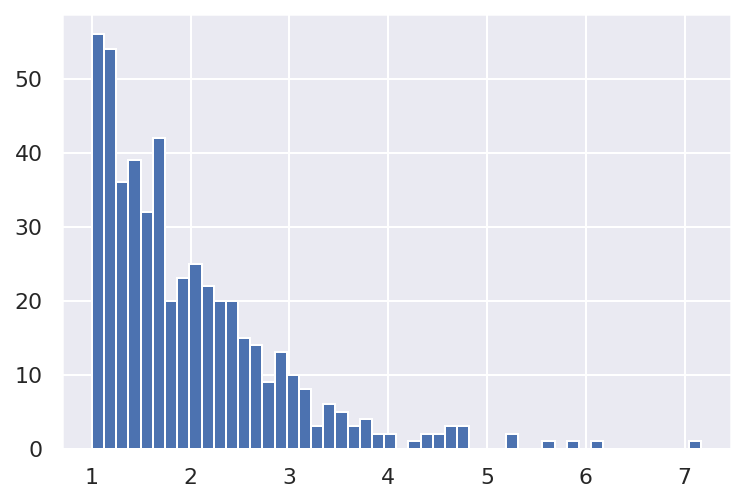

In [26]:
_ = plt.hist(prior_samples['power'].flatten(), bins=50)

Mostly, we want to see that the prior predictions cover all of the data and do not exclude plausible outcomes.

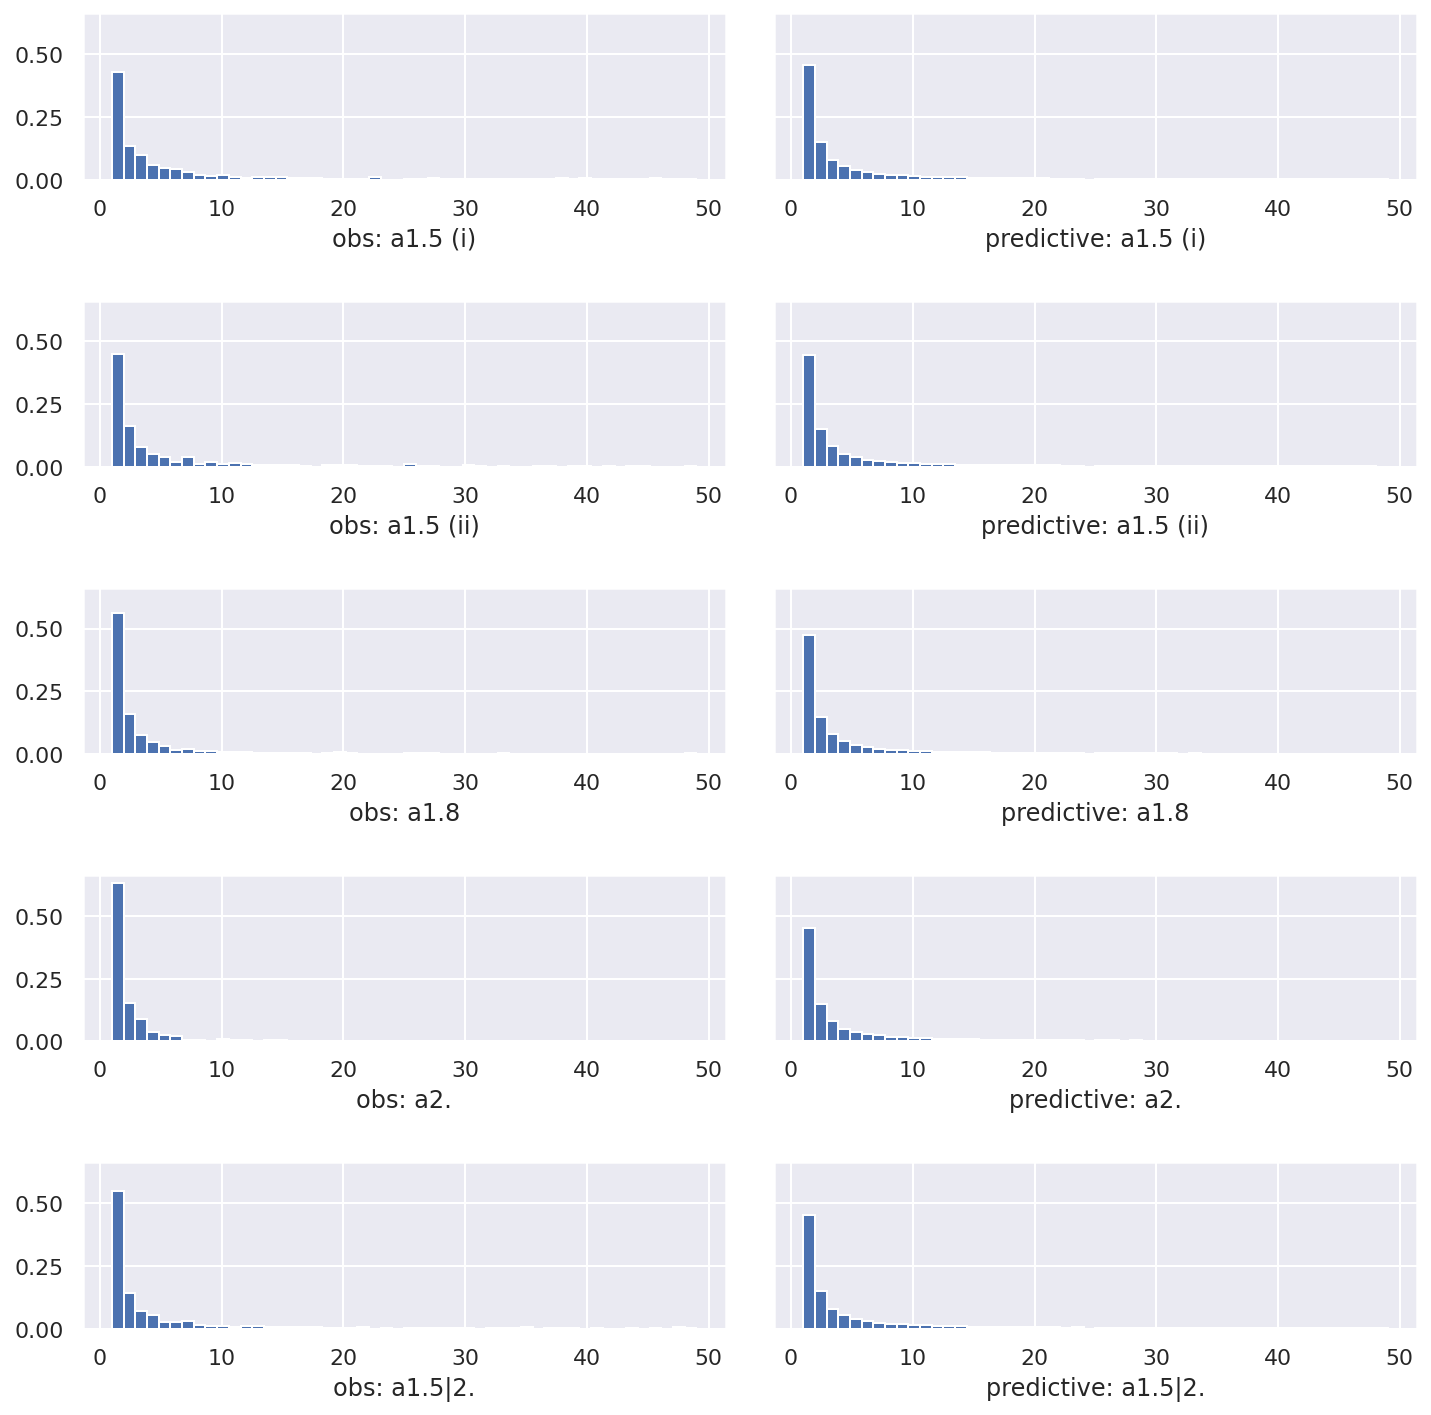

In [27]:
_ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30], figsize=(10, 10), kind='draw')

We can summarise the prior predictions in terms of relevant statistics and plot their distribution against the observed value of said statistics:

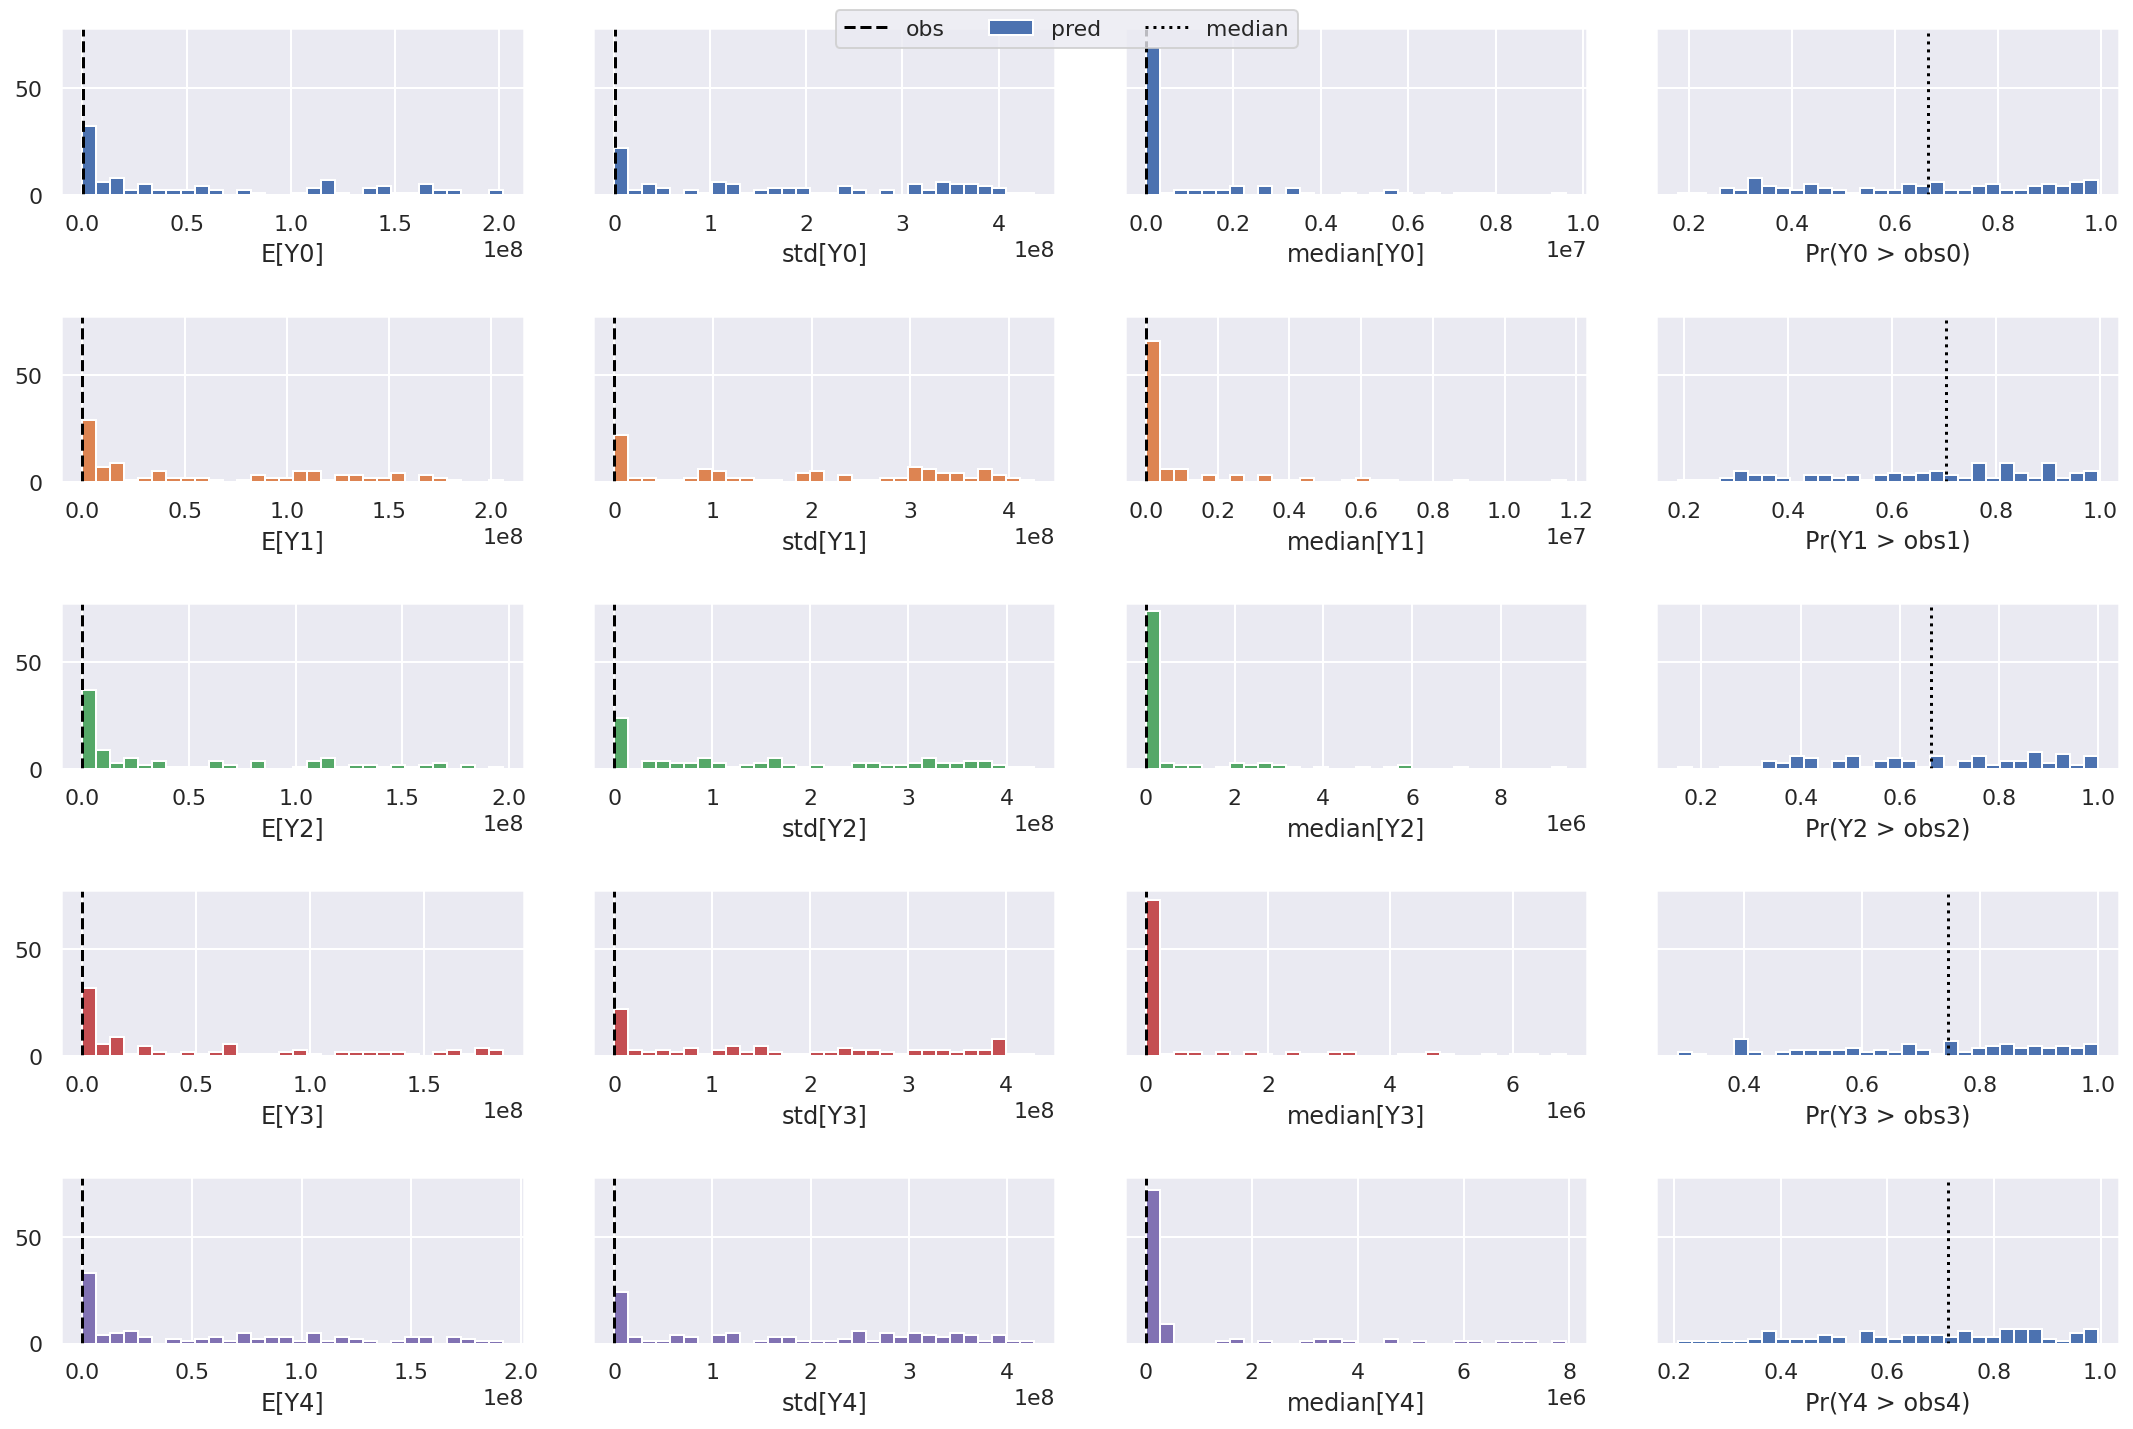

In [28]:
_ = plot_checks(model, prior_samples['y'], figsize=(15, 10))

If our statistics fall roughly in the bulk of the histograms above, we are good to go. 

Next we condition on all obserations and draw posterior samples via MCMC.

In [29]:
model.run()

sample: 100%|██████████| 2500/2500 [02:22<00:00, 17.54it/s, 63 steps of size 6.29e-02. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.98      0.03      0.99      0.95      1.00   1897.84      1.00
 beta[0,1]      0.68      0.30      0.79      0.20      1.00   2656.06      1.00
 beta[0,2]      0.68      0.30      0.78      0.20      1.00   2488.01      1.00
 beta[0,3]      0.67      0.30      0.75      0.20      1.00   3218.97      1.00
 beta[1,0]      0.87      0.10      0.88      0.74      1.00    864.60      1.00
 beta[1,1]      0.74      0.27      0.84      0.30      1.00   2753.34      1.00
 beta[1,2]      0.68      0.29      0.77      0.21      1.00   2555.74      1.00
 beta[1,3]      0.67      0.30      0.75      0.20      1.00   3501.28      1.00
 beta[2,0]      0.16      0.09      0.15      0.00      0.28    771.39      1.00
 beta[2,1]      0.82      0.21      0.90      0.49      1.00   1262.20      1.00
 beta[2,2]      0.71      0.28      0.80      0.27      1.00   2243.30      1.00
 beta[2,3]      0.67      0

We also obtain posterior predictions:

In [30]:
posterior_samples = model.draw_posterior_predictions()

In [31]:
print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))

rv       shape
-------  ---------------
omega    (2000, 5, 5)
omega_x  (2000, 5000, 5)
power    (2000, 5)
y        (2000, 5000)
z        (2000, 5000)


As our individual outcomes are low dimensional, we can just plot the posterior predictions against the observations:

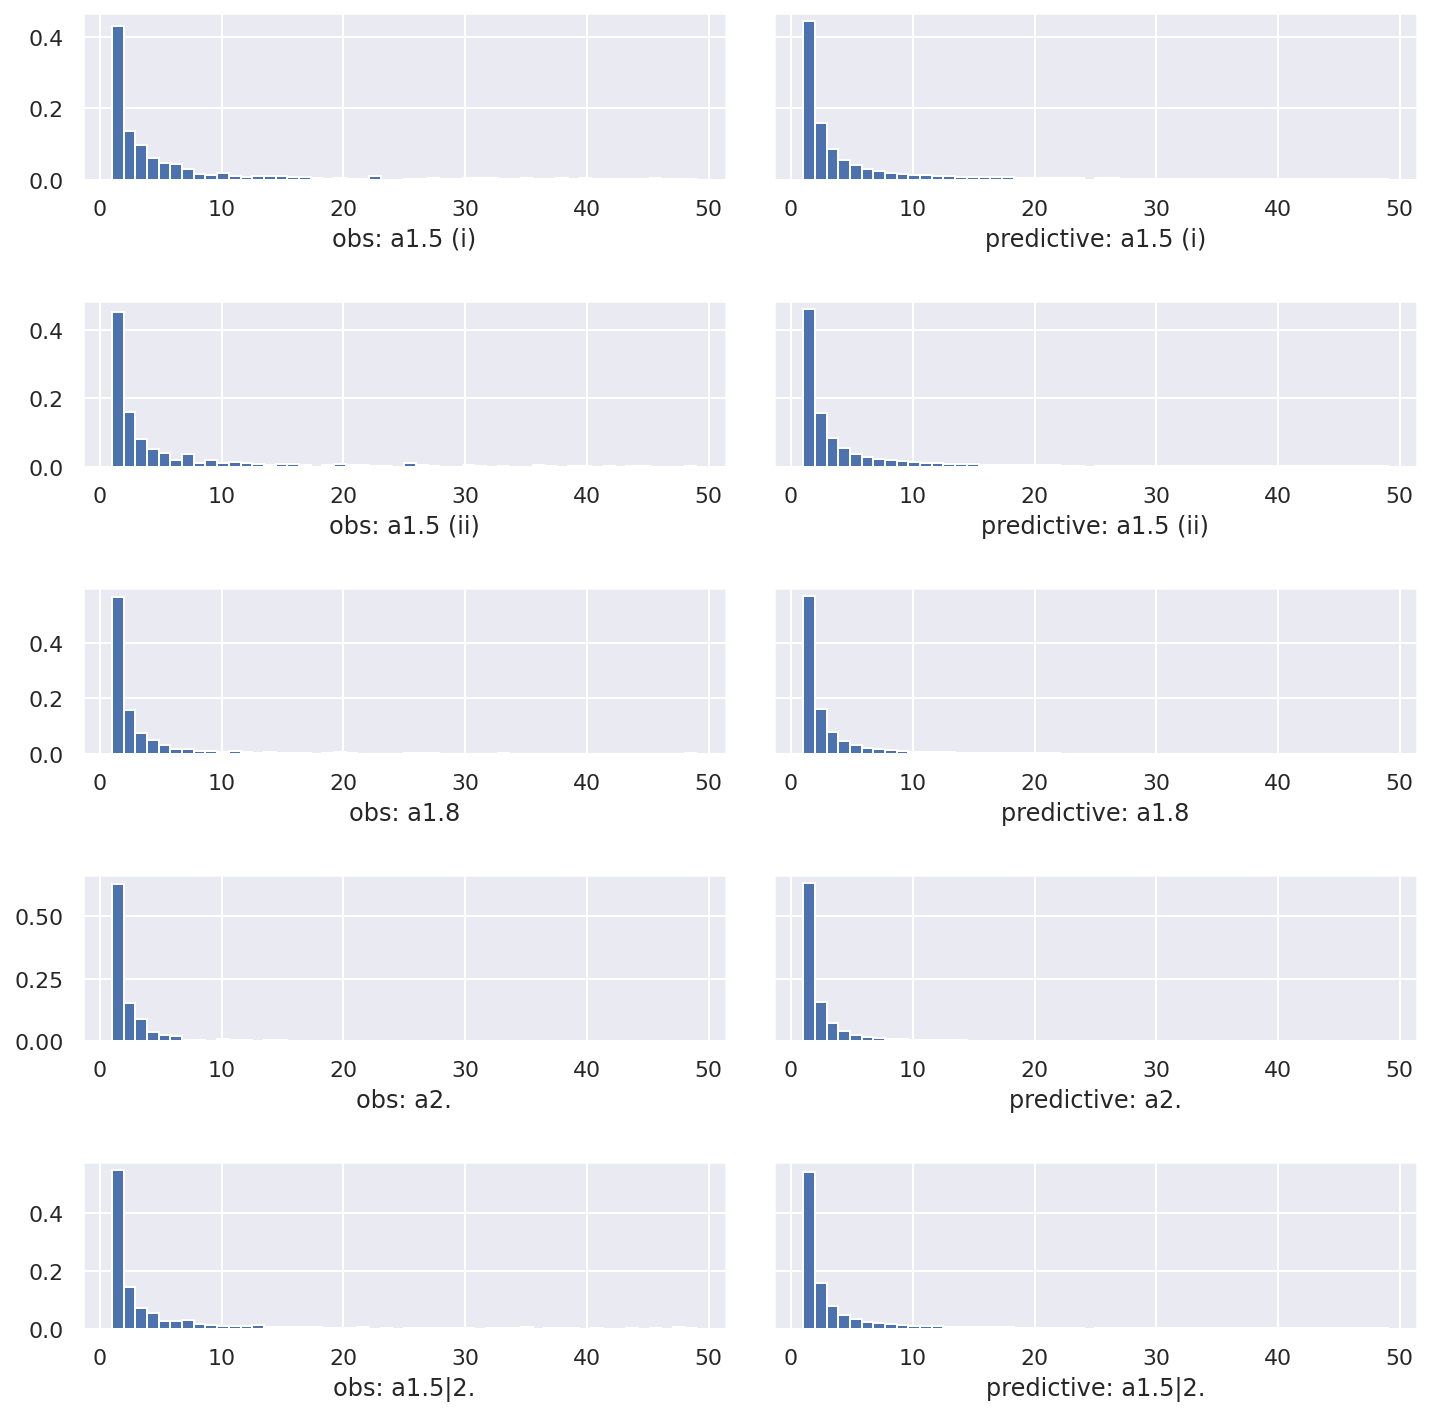

In [32]:
_ = plot_predictions(model, posterior_samples['y'], bins=[50, 50], sharex='row', sharey='row', figsize=(10, 10), kind='draw')

We can also compute checks against statistics of the predictions:

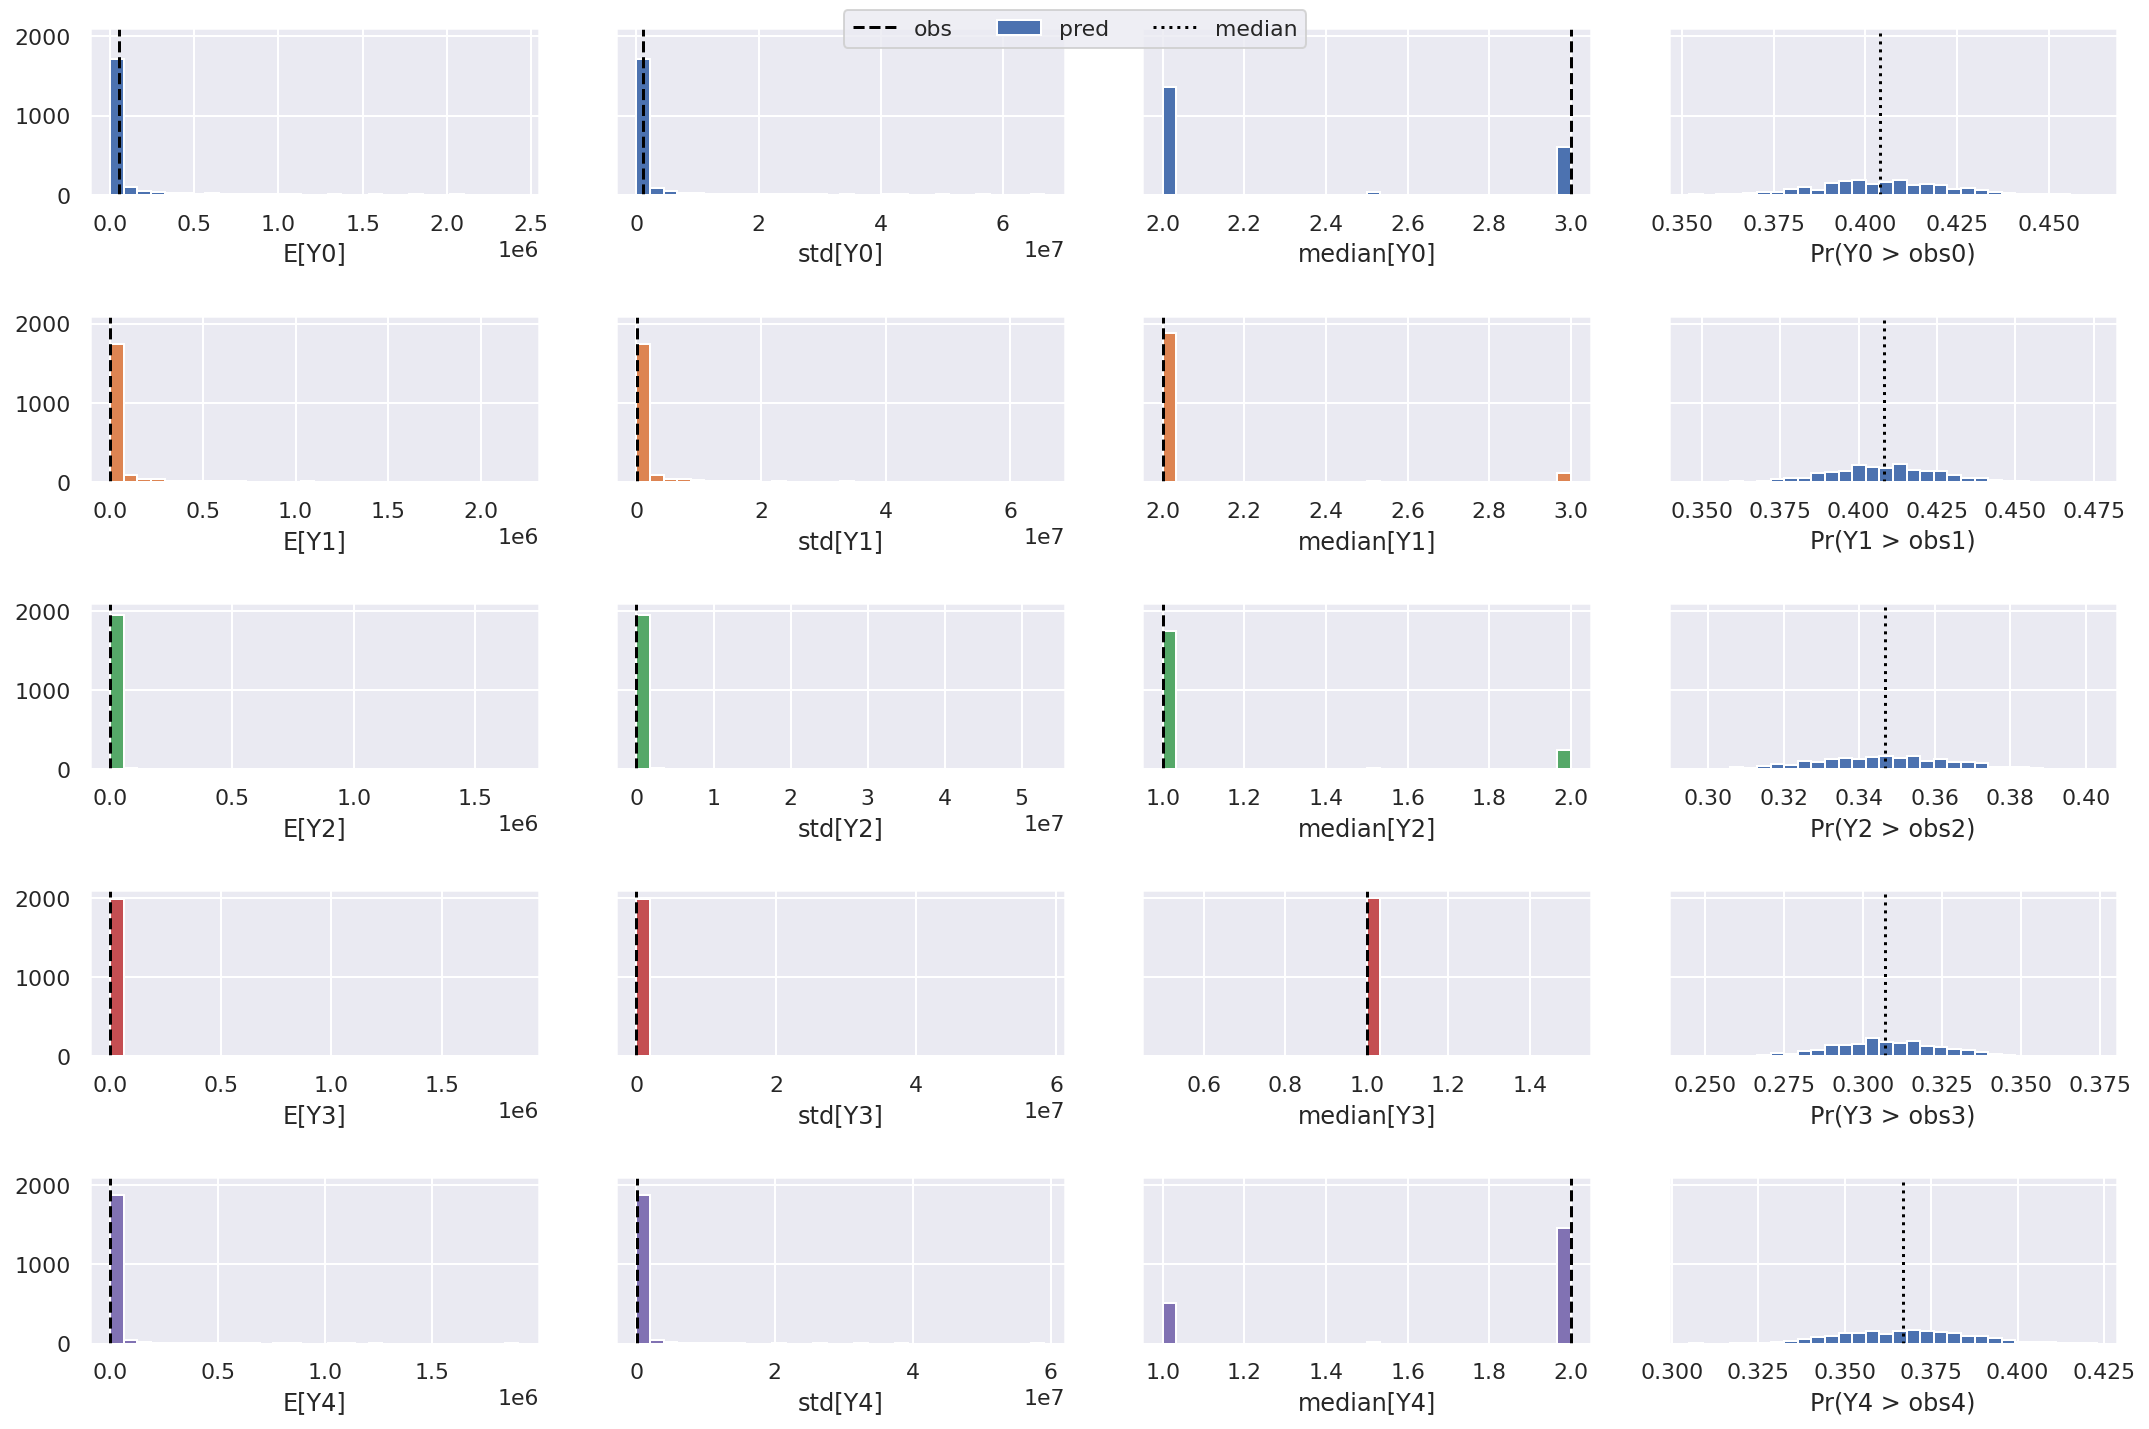

In [33]:
_ = plot_checks(model, posterior_samples['y'], figsize=(15, 10))

As our model is a mixture model, we might be interested in posterior component assignments:

In [34]:
# local_samples = model.infer_local_assignments(model.posterior_samples, model.y)

In [35]:
# print(tabulate([(k, v.shape) for k, v in local_samples.items()], headers=['rv', 'shape']))

We should observe some correlation between the component's rate and the observations (for a Poisson model this is to be expected).

In [36]:
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
# pal = cycle(sns.color_palette())
# _ = ax[0].scatter(model.y, np.mean(local_samples['rate_z'], 0), color=next(pal), label='mean')
# _ = ax[0].scatter(model.y, np.median(local_samples['rate_z'], 0), color=next(pal), label='median')
# _ = ax[1].scatter(jnp.repeat(model.y[None,:], 100, 0).flatten(), local_samples['rate_z'][:100,:].flatten(), color=next(pal), label='100 samples')
# _ = ax[0].set_xlabel('observation')
# _ = ax[0].set_ylabel('local rate')
# _ = ax[1].set_xlabel('observation')
# fig.tight_layout(h_pad=1, w_pad=1)
# _ = fig.legend()

We can inspect the mixing coefficients for the different groups:

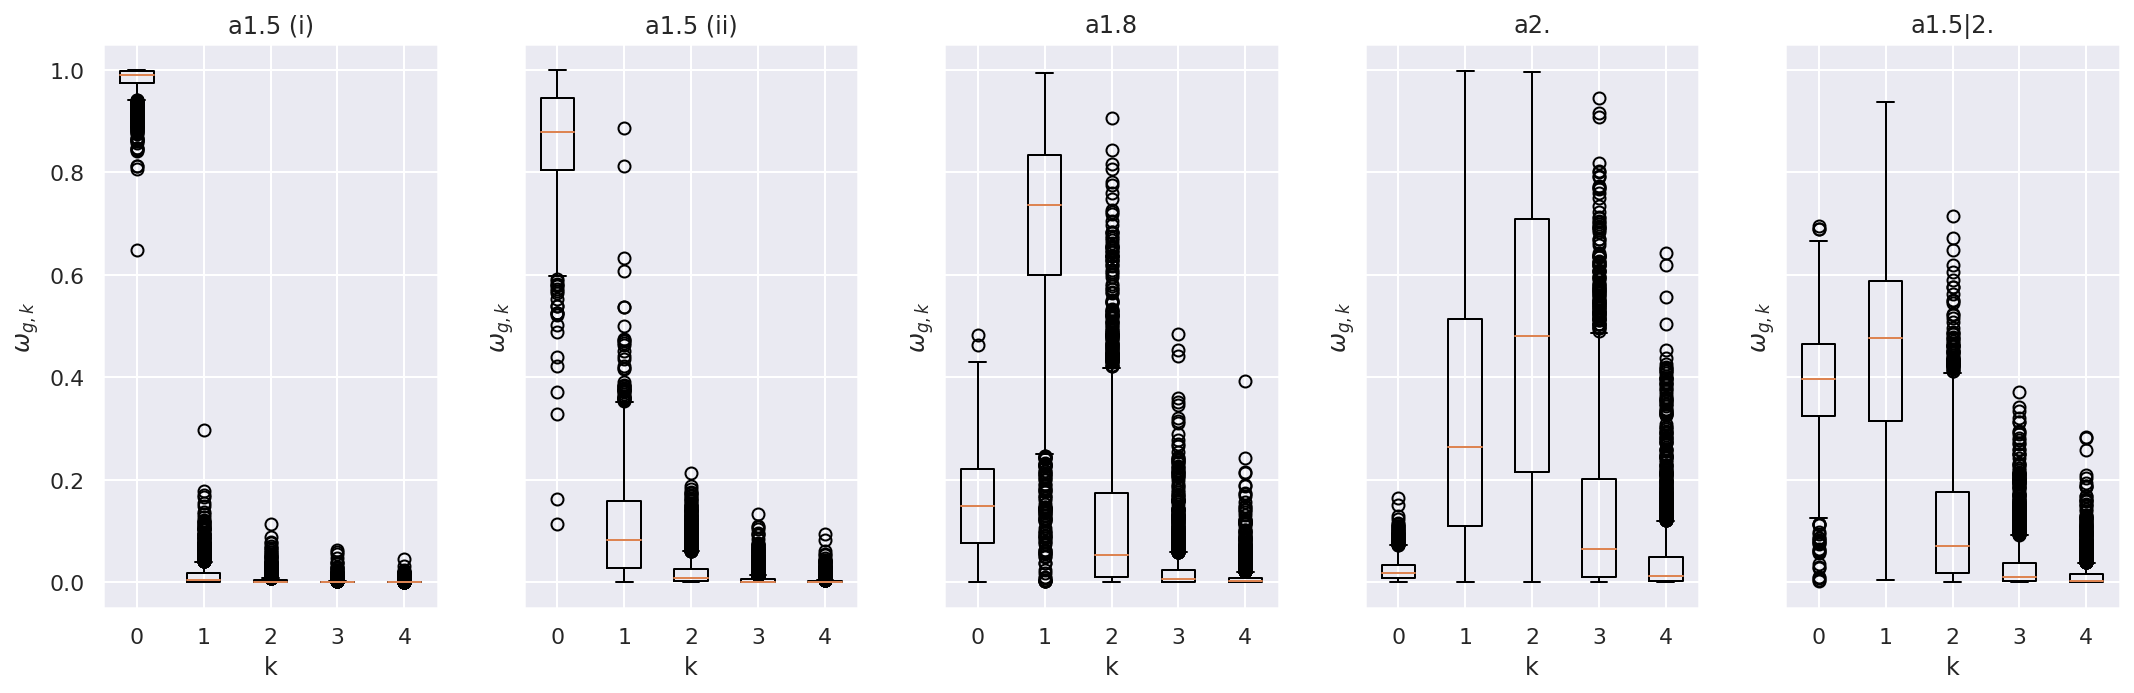

In [37]:
fig, ax = plt.subplots(1, model.G, sharex=True, sharey=True, figsize=(15, 5))
if model.G == 1:
    ax = [ax]    
for g in range(model.G):
    if model.G > 1:
        w = posterior_samples['omega'][:,g,:].transpose()
    else:
        w = posterior_samples['omega'].transpose()
    _ = ax[g].boxplot(w)
    _ = ax[g].set_xticklabels(np.arange(model.T))
    _ = ax[g].set_title(model.group_names[g])
    _ = ax[g].set_xlabel('k')
    _ = ax[g].set_ylabel(r'$\omega_{g,k}$')
fig.tight_layout(h_pad=2, w_pad=2)

And, assuming the 0th group is somewhat special, we can use it to estimate a lowerbound on the KL divergence between groups.

This should be close to 0 for the group `r5b` of the demo (which is sampled from the same Poisson as the group the 0th group `r5a`).

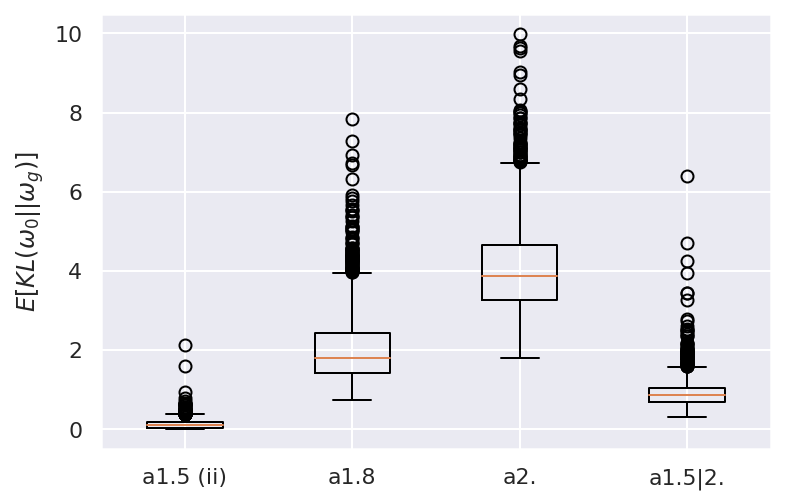

In [38]:
if model.G > 1:
    kls = []
    for g in range(model.G):
        p = posterior_samples['omega'][:,0,:]
        q = posterior_samples['omega'][:,g,:]
        kls.append((p * (np.log(p) - np.log(q))).sum(-1))

    _ = plt.boxplot(kls[1:])
    _ = plt.ylabel(r'$E[KL(\omega_0||\omega_g)]$')
    _ = plt.xticks(np.arange(model.G - 1) + 1, model.group_names[1:]) 

In [39]:
# _ = plt.hist(model.posterior_samples['scale'].flatten(), bins='auto')

We can now visualise the components, and their assignments.

This model should retrieve all 3 components that are needed to explain this collection. Of course, this will also depend on prior parameters such as the DP concentration, if too small the model will prefer fewer components (in a balanced dataset, this might mean merging components that are nearby in parameter space, in an unbalanced dataset this might mean dropping less represented components, that's why the posterior predictive checks we report above are important).

The plot shows:

1. samples from the posterior component (i.e., draws from Zipf(s))
2. posterior component's parameters (i.e., s)
3. posterior mixing weights


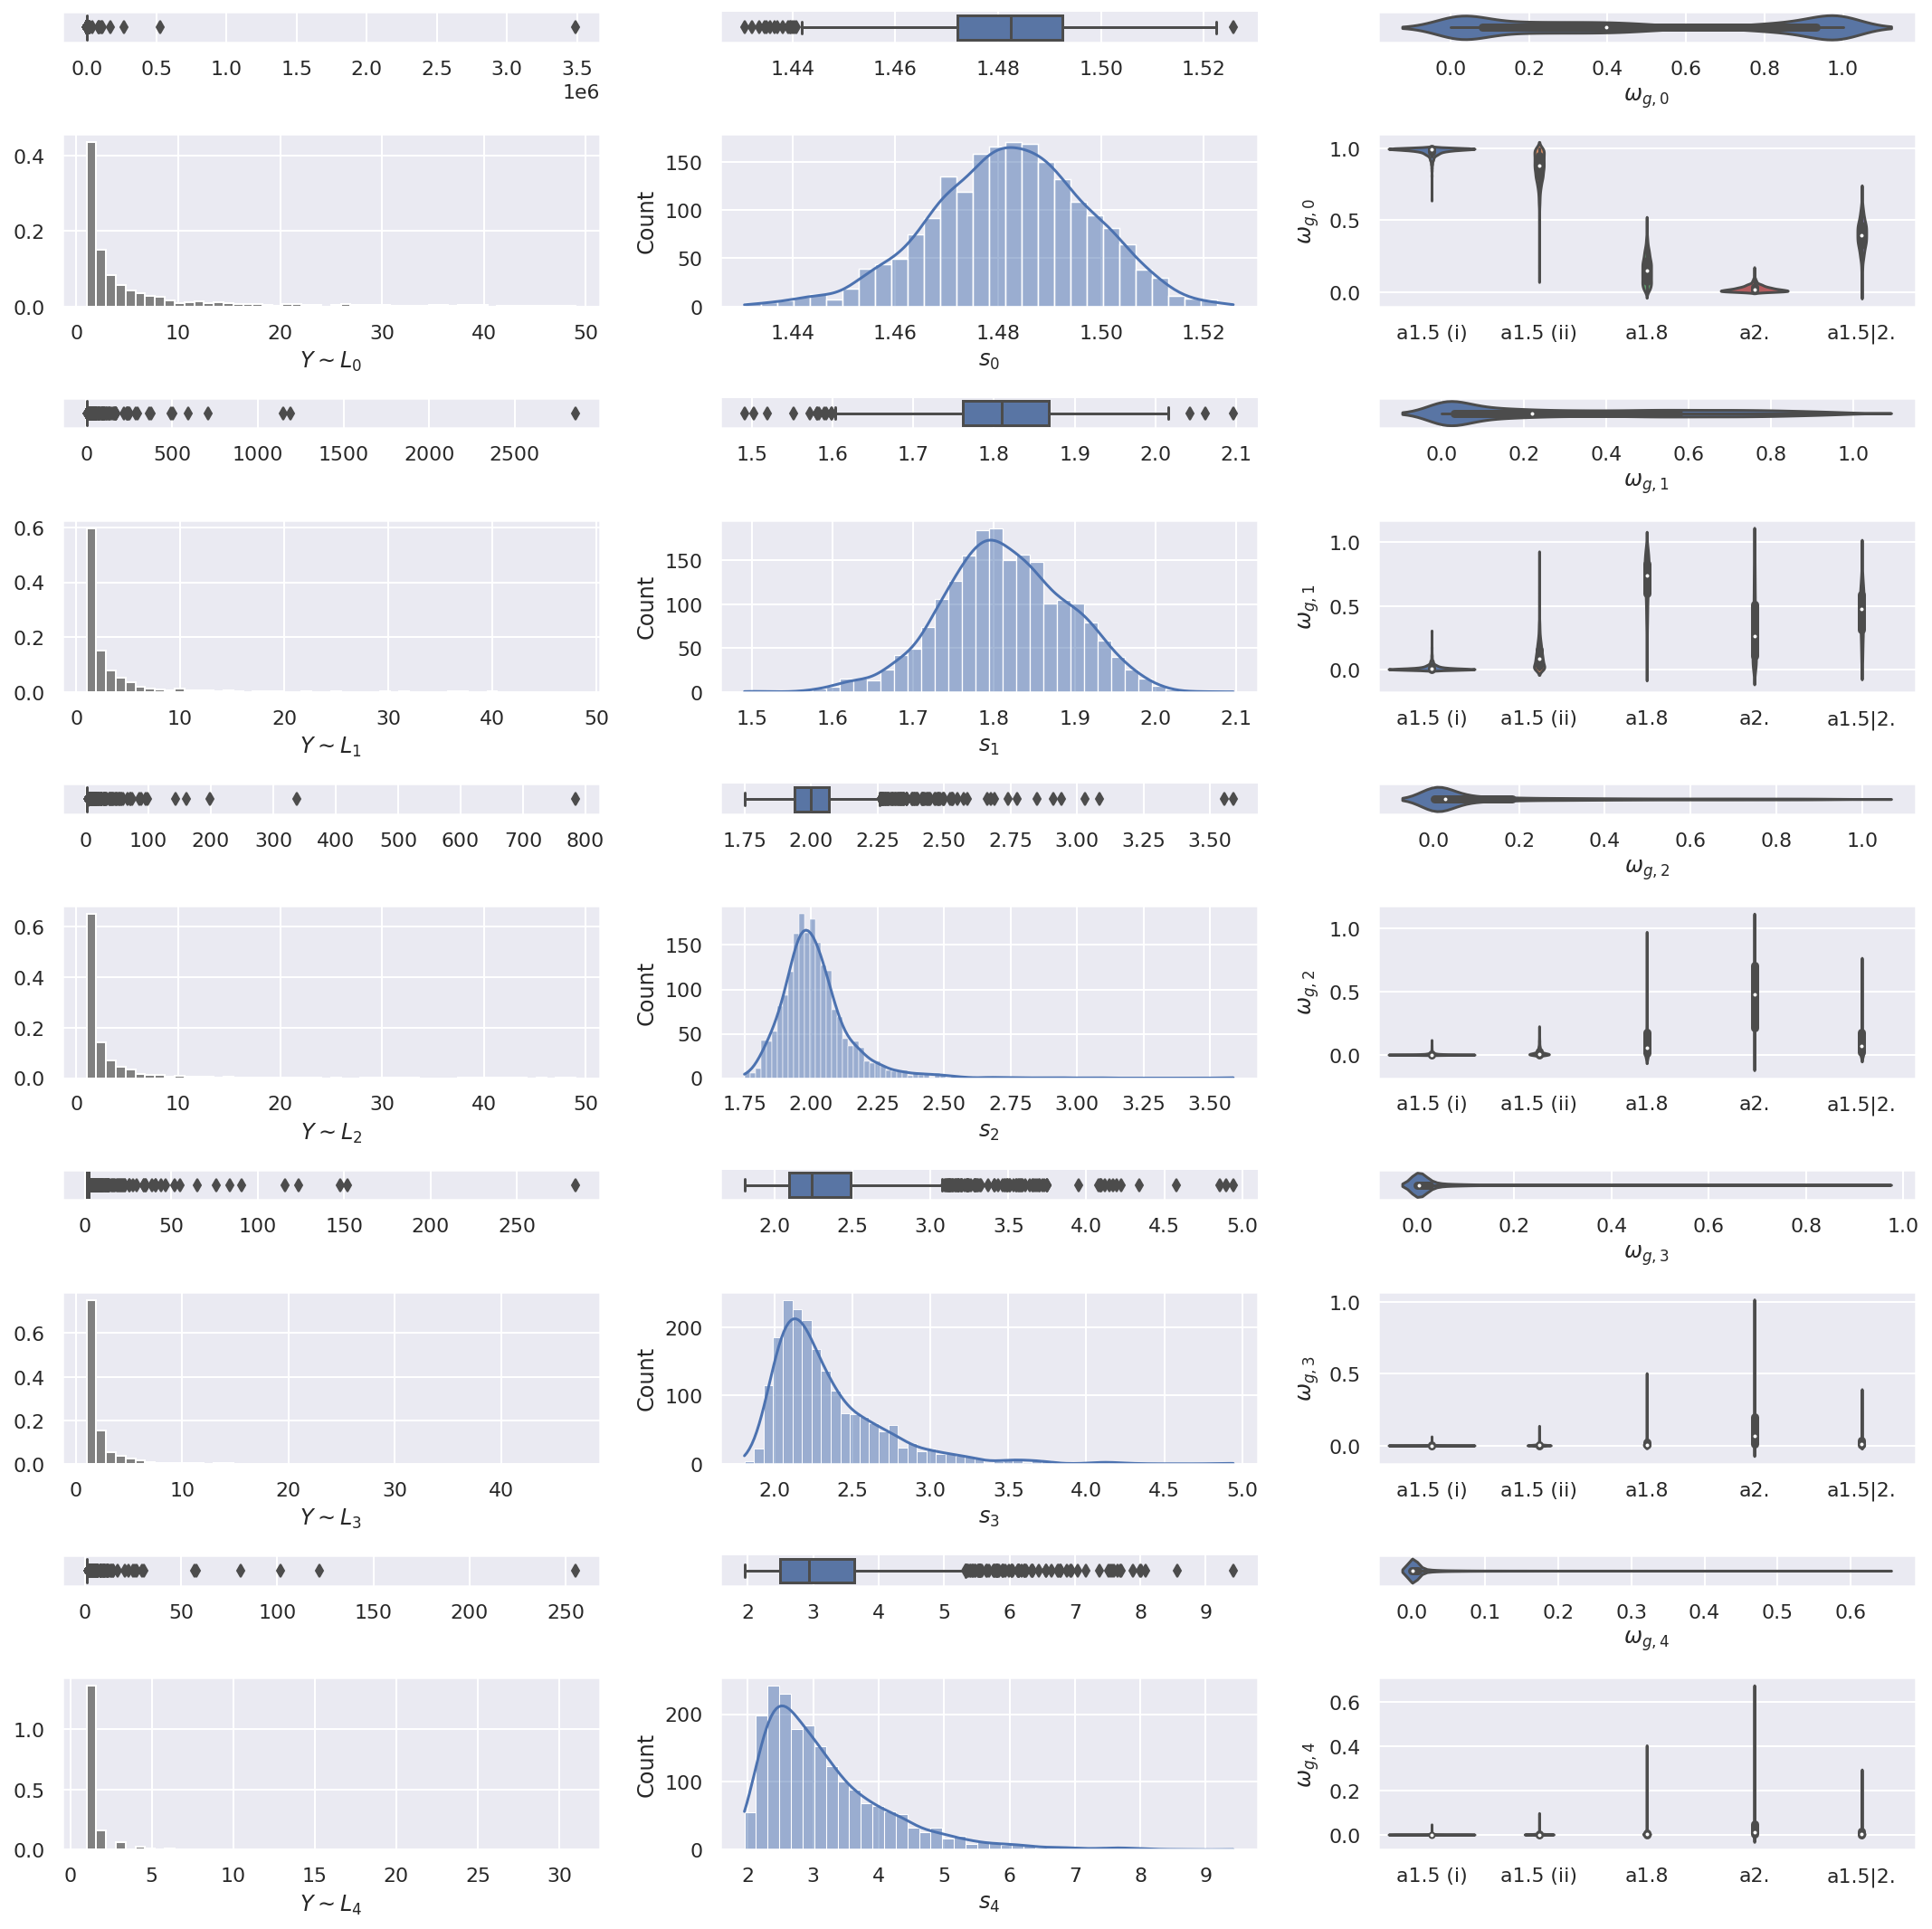

In [40]:
import pandas as pd

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
fig, ax = plt.subplots(model.T * 2, 3, figsize=(15, 15), gridspec_kw={"height_ratios": np.tile([.15, 0.85], model.T)})

df_dict = {'group': np.tile(model.group_names, model.posterior_samples['omega'].shape[0])}

for t in range(model.T):
  df_dict[f'omega{t}'] = model.posterior_samples['omega'][:,:,t].flatten()

df = pd.DataFrame(df_dict)

for t in range(model.T):
    y_t = np.random.zipf(model.posterior_samples['power'][:, t])
    _ = sns.boxplot(x=y_t, ax=ax[2*t,0])
    _ = ax[2*t,0].set(yticks=[])
    _ = plot_draws(y_t, ax=ax[1+2*t, 0], color='gray')        
    _ = ax[1+2*t, 0].set_xlabel(r'$Y \sim L_{%d}$' % t)

    _ = sns.boxplot(x=model.posterior_samples['power'][:, t], ax=ax[2*t,1])
    _ = ax[2*t,1].set(yticks=[])
    _ = sns.histplot(x=model.posterior_samples['power'][:, t], ax=ax[1+2*t, 1], kde=True)
    _ = ax[1+2*t, 1].set_xlabel(r'$s_{%d}$' % t)

    sns.despine(ax=ax[2*t, 1])
    # sns.despine(ax=ax[2*t, 1], left=True)

    _ = sns.violinplot(x=model.posterior_samples['omega'][:,:,t].flatten(), ax=ax[2*t,2])
    _ = ax[2*t,2].set(yticks=[])
    _ = ax[2*t, 2].set_xlabel(r"$\omega_{g,%d}$" % t) 
    _ = sns.violinplot(x='group', y=f'omega{t}', data=df, ax=ax[1+2*t,2])
    _ = ax[1+2*t, 2].set_ylabel(r'$\omega_{g,%d}$' % t)    
    _ = ax[1+2*t, 2].set_xlabel("") 
    
# fig.legend(np.arange(model.G), group_names)
fig.tight_layout(h_pad=1, w_pad=1)